# Logistic Regression

In this part of the exercise, you will build a logistic regression model to predict whether a student gets admitted into a university.

<a name="2.1"></a>
###  Problem Statement

Suppose that you are the administrator of a university department and you want to determine each applicant’s chance of admission based on their results on two exams. 
* You have historical data from previous applicants that you can use as a training set for logistic regression. 
* For each training example, you have the applicant’s scores on two exams and the admissions decision. 
* Your task is to build a classification model that estimates an applicant’s probability of admission based on the scores from those two exams. 

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
import copy
import math

%matplotlib inline

### Loading and visualizing the data

You will start by loading the dataset for this task. 
- The `load_dataset()` function shown below loads the data into variables `X_train` and `y_train`
  - `X_train` contains exam scores on two exams for a student
  - `y_train` is the admission decision 
      - `y_train = 1` if the student was admitted 
      - `y_train = 0` if the student was not admitted 
  - Both `X_train` and `y_train` are numpy arrays.

In [65]:
X_train, y_train = load_data("data/ex2data1.txt")

In [66]:
print('First five features', X_train[:5])
print('First five targets', y_train[:5])

First five features [[34.62365962 78.02469282]
 [30.28671077 43.89499752]
 [35.84740877 72.90219803]
 [60.18259939 86.3085521 ]
 [79.03273605 75.34437644]]
First five targets [0. 0. 0. 1. 1.]


In [67]:
print(X_train.shape, y_train.shape)

(100, 2) (100,)


#### Visualize your data

Before starting to implement any learning algorithm, it is always good to visualize the data if possible.
- The code below displays the data on a 2D plot (as shown below), where the axes are the two exam scores, and the positive and negative examples are shown with different markers.
- We use a helper function in the ``utils.py`` file to generate this plot. 

Your goal is to build a logistic regression model to fit this data.
- With this model, you can then predict if a new student will be admitted based on their scores on the two exams.

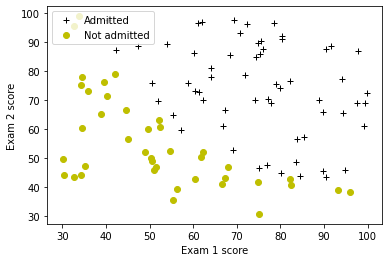

In [68]:
plot_data(X_train, y_train[:], pos_label="Admitted", neg_label="Not admitted")

plt.ylabel('Exam 2 score') 
plt.xlabel('Exam 1 score') 
plt.legend(loc="upper left")
plt.show()

### Sigmoid function

Recall that for logistic regression, the model is represented as

$$ f_{\mathbf{w},b}(x) = g(\mathbf{w}\cdot \mathbf{x} + b)$$
where function $g$ is the sigmoid function. The sigmoid function is defined as:

$$g(z) = \frac{1}{1+e^{-z}}$$

Let's implement the sigmoid function first, so it can be used by the rest of this assignment.

$$g(z) = \frac{1}{1+e^{-z}}$$

Note that 
- `z` is not always a single number, but can also be an array of numbers. 
- If the input is an array of numbers, we'd like to apply the sigmoid function to each value in the input array.

In [69]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Args:
        z (ndarray): A scalar, numpy array of any size.

    Returns:
        g (ndarray): sigmoid(z), with the same shape as z
         
    """
          
    g = 1/(1+np.exp(-z))   
    return g

Note that for large positive values of `z`, sigmoid function will be close to 1 and for small negative values of `z`, sigmoid function will be close to 0

In [70]:
print ("sigmoid(0) = " + str(sigmoid(0)))
print ("sigmoid(-100) = " + str(sigmoid(-100)))
print ("sigmoid(100) = " + str(sigmoid(100)))
print ("sigmoid([ -1, 0, 1, 2]) = " + str(sigmoid(np.array([-1, 0, 1, 2]))))

sigmoid(0) = 0.5
sigmoid(-100) = 3.7200759760208356e-44
sigmoid(100) = 1.0
sigmoid([ -1, 0, 1, 2]) = [0.26894142 0.5        0.73105858 0.88079708]


### Cost function for logistic regression
Recall that for logistic regression, the cost function is of the form 

$$ J(\mathbf{w},b) = \frac{1}{m}\sum_{i=0}^{m-1} \left[ loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) \right] \tag{1}$$

where
* m is the number of training examples in the dataset


* $loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)})$ is the cost for a single data point, which is - 

    $$loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) = (-y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) \tag{2}$$
    
    
*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ is the model's prediction, while $y^{(i)}$, which is the actual label

*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = g(\mathbf{w} \cdot \mathbf{x^{(i)}} + b)$ where function $g$ is the sigmoid function.
    * It might be helpful to first calculate an intermediate variable $z_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x^{(i)}} + b = w_0x^{(i)}_0 + ... + w_{n-1}x^{(i)}_{n-1} + b$ where $n$ is the number of features, before calculating $f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = g(z_{\mathbf{w},b}(\mathbf{x}^{(i)}))$

Note:
* As you are doing this, remember that the variables `X_train` and `y_train` are not scalar values but matrices of shape ($m, n$) and ($𝑚$,1) respectively, where  $𝑛$ is the number of features and $𝑚$ is the number of training examples.
* You can use the sigmoid function that you implemented above for this part.

In [71]:
def compute_cost(X, y, w, b, lambda_= 1):
    """
    Computes the cost over all examples
    Args:
      X : (ndarray Shape (m,n)) data, m examples by n features
      y : (array_like Shape (m,)) target value 
      w : (array_like Shape (n,)) Values of parameters of the model      
      b : scalar Values of bias parameter of the model
      lambda_: unused placeholder
    Returns:
      total_cost: (scalar)   cost 
    """

    m, n = X.shape
    
    total_cost = 0.0
    for i in range(m):
        z_i = np.dot(X[i],w) + b
        f_wb_i = sigmoid(z_i)
        total_cost +=  -y[i]*np.log(f_wb_i) - (1-y[i])*np.log(1-f_wb_i)
             
    total_cost = total_cost / m
    return total_cost

In [72]:
m, n = X_train.shape

initial_w = np.zeros(n)
initial_b = 0.
cost = compute_cost(X_train, y_train, initial_w, initial_b)
print('Cost at w, b: {:.3f}'.format(cost))

Cost at w, b: 0.693


In [73]:
test_w = np.array([0.2, 0.2])
test_b = -24

cost = compute_cost(X_train, y_train, test_w, test_b)
print('Cost at w, b: {:.3f}'.format(cost))

Cost at w, b: 0.218



### Gradient for logistic regression

Recall that the gradient descent algorithm is:

$$\begin{align*}& \text{repeat until convergence:} \; \lbrace \newline \; & b := b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b} \newline       \; & w_j := w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{1}  \; & \text{for j := 0..n-1}\newline & \rbrace\end{align*}$$

where, parameters $b$, $w_j$ are all updated simultaniously

In [74]:
def compute_gradient(X, y, w, b, lambda_=None): 
    """
    Computes the gradient for logistic regression 
 
    Args:
      X : (ndarray Shape (m,n)) variable such as house size 
      y : (array_like Shape (m,1)) actual value 
      w : (array_like Shape (n,1)) values of parameters of the model      
      b : (scalar)                 value of parameter of the model 
      lambda_: unused placeholder.
    Returns
      dj_dw: (array_like Shape (n,1)) The gradient of the cost w.r.t. the parameters w. 
      dj_db: (scalar)                The gradient of the cost w.r.t. the parameter b. 
    """
    m, n = X.shape
    dj_dw = np.zeros(w.shape)
    dj_db = 0.

    for i in range(m):
        f_wb_i = sigmoid(np.dot(X[i],w) + b)          
        err_i  = f_wb_i  - y[i]                       
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err_i * X[i,j]      
        dj_db = dj_db + err_i
    dj_dw = dj_dw/m                                   
    dj_db = dj_db/m                                   
        
    return dj_db, dj_dw

In [75]:
initial_w = np.zeros(n)
initial_b = 0.

dj_db, dj_dw = compute_gradient(X_train, y_train, initial_w, initial_b)
print(f'dj_db at initial w (zeros):{dj_db}' )
print(f'dj_dw at initial w (zeros):{dj_dw.tolist()}' )

dj_db at initial w (zeros):-0.1
dj_dw at initial w (zeros):[-12.00921658929115, -11.262842205513591]


In [76]:
test_w = np.array([ 0.2, -0.5])
test_b = -24
dj_db, dj_dw  = compute_gradient(X_train, y_train, test_w, test_b)

print('dj_db at test_w:', dj_db)
print('dj_dw at test_w:', dj_dw.tolist())

dj_db at test_w: -0.5999999999991071
dj_dw at test_w: [-44.831353617873795, -44.37384124953978]


### Learning parameters using gradient descent 
 

If you have implemented the gradient and computed the cost correctly, your value of $J(\mathbf{w},b)$ should never increase, and should converge to a steady value by the end of the algorithm.

In [77]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_): 
    """
    Performs batch gradient descent to learn theta. Updates theta by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X :    (array_like Shape (m, n)
      y :    (array_like Shape (m,))
      w_in : (array_like Shape (n,))  Initial values of parameters of the model
      b_in : (scalar)                 Initial value of parameter of the model
      cost_function:                  function to compute cost
      alpha : (float)                 Learning rate
      num_iters : (int)               number of iterations to run gradient descent
      lambda_ (scalar, float)         regularization constant
      
    Returns:
      w : (array_like Shape (n,)) Updated values of parameters of the model after
          running gradient descent
      b : (scalar)                Updated value of parameter of the model after
          running gradient descent
    """
    
    # number of training examples
    m = len(X)
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w_history = []
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db, dj_dw = gradient_function(X, y, w_in, b_in, lambda_)   

        # Update Parameters using w, b, alpha and gradient
        w_in = w_in - alpha * dj_dw               
        b_in = b_in - alpha * dj_db              
       
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            cost =  cost_function(X, y, w_in, b_in, lambda_)
            J_history.append(cost)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0 or i == (num_iters-1):
            w_history.append(w_in)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")
        
    return w_in, b_in, J_history, w_history #return w and J,w history for graphing

In [119]:
np.random.seed(1)
intial_w = 0.01 * (np.random.rand(2).reshape(-1,1) - 0.5)
initial_b = -8

iterations = 10000
alpha = 0.001

w,b, J_history,_ = gradient_descent(X_train ,y_train, initial_w, initial_b, compute_cost, compute_gradient, alpha, iterations, 0)

Iteration    0: Cost     1.01   
Iteration 1000: Cost     0.31   
Iteration 2000: Cost     0.30   
Iteration 3000: Cost     0.30   
Iteration 4000: Cost     0.30   
Iteration 5000: Cost     0.30   
Iteration 6000: Cost     0.30   
Iteration 7000: Cost     0.30   
Iteration 8000: Cost     0.30   
Iteration 9000: Cost     0.30   
Iteration 9999: Cost     0.30   


In [122]:
# intial_w = np.random.randn(2)
# initial_b = 10

# iterations = 1000
# alpha = 0.001

# w,b, J_history,_ = gradient_descent(X_train, y_train, initial_w, initial_b, compute_cost, compute_gradient, alpha, iterations, lambda_=2)

### Plotting the decision boundary

We will now use the final parameters from gradient descent to plot the linear fit.

We will use a helper function in the `utils.py` file to create this plot.

In [123]:
print(w, b)
print(initial_w, initial_b)

[0.07125349 0.06482881] -8.188614567810179
[0. 0.] -8


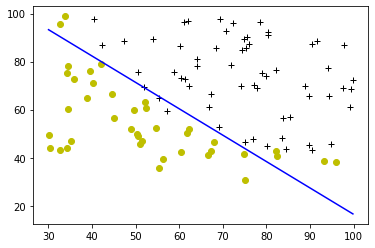

In [124]:
plot_decision_boundary(w, b, X_train, y_train)

### Evaluating logistic regression

We can evaluate the quality of the parameters we have found by seeing how well the learned model predicts on our training set. 

Implement the `predict` function below to do this.
Therefore, to get a final prediction ($y^{(i)}=0$ or $y^{(i)}=1$) from the logistic regression model, you can use the following heuristic -

  if $f(x^{(i)}) >= 0.5$, predict $y^{(i)}=1$
  
  if $f(x^{(i)}) < 0.5$, predict $y^{(i)}=0$

In [125]:
def predict(X, w, b): 
        m, n = X.shape   
        p = np.zeros(m)
        
        for i in range(m):
            z_i = np.dot(X[i], w) + b
            f_wb = sigmoid(z_i)
            p[i] = f_wb >= 0.5
    
        return p

In [143]:
print(tmp_w.shape)
print(tmp_X.shape)
print(tmp_X)

(2,)
(4, 2)
[[-1.02817175 -1.57296862]
 [ 0.36540763 -2.8015387 ]
 [ 1.24481176 -1.2612069 ]
 [-0.1809609  -0.74937038]]


In [126]:
# Test your predict code
np.random.seed(1)
tmp_w = np.random.randn(2)
tmp_b = 0.3    
tmp_X = np.random.randn(4, 2) - 0.5

tmp_p = predict(tmp_X, tmp_w, tmp_b)
print(f'Output of predict: shape {tmp_p.shape}, value {tmp_p}')

Output of predict: shape (4,), value [0. 1. 1. 1.]


In [128]:
w_1 = np.random.randint(12, size=2)
b_1 = 0.2
X_1 = np.random.randn(4, 2)
pred = predict(X_1, w_1, b_1)
print('prediction:', pred)

prediction: [0. 0. 0. 0.]


Accuracy on the training set

In [136]:
p = predict(X_train, w, b)
print('Train Accuracy: %f'%(np.mean(p == y_train) * 100))

Train Accuracy: 92.000000


## Regularized Logistic Regression

We will implement regularized logistic regression to predict whether microchips from a fabrication plant passes quality assurance (QA). During QA, each microchip goes through various tests to ensure it is functioning correctly.

### Problem Statement

Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests. 
- From these two tests, you would like to determine whether the microchips should be accepted or rejected. 
- To help you make the decision, you have a dataset of test results on past microchips, from which you can build a logistic regression model.

### Loading and visualizing the data 

- The `load_dataset()` function shown below loads the data into variables `X_train` and `y_train`
  - `X_train` contains the test results for the microchips from two tests
  - `y_train` contains the results of the QA  
      - `y_train = 1` if the microchip was accepted 
      - `y_train = 0` if the microchip was rejected 
  - Both `X_train` and `y_train` are numpy arrays.

In [145]:
X_train, y_train = load_data("data/ex2data2.txt")

In [147]:
print('First five features:\n', X_train[:5])
print('First five targets:', y_train[:5])

First five features:
 [[ 0.051267  0.69956 ]
 [-0.092742  0.68494 ]
 [-0.21371   0.69225 ]
 [-0.375     0.50219 ]
 [-0.51325   0.46564 ]]
First five targets: [1. 1. 1. 1. 1.]


In [150]:
print('The shape of X_train is:', X_train.shape)
print('The shape of y_train is:', y_train.shape)
print('There are m = {} training examples'.format(len(y_train)))

The shape of X_train is: (118, 2)
The shape of y_train is: (118,)
There are m = 118 training examples


#### Visualize your data

The helper function `plot_data` (from `utils.py`) is used to generate a figure like Figure 3, where the axes are the two test scores, and the positive (y = 1, accepted) and negative (y = 0, rejected) examples are shown with different markers.

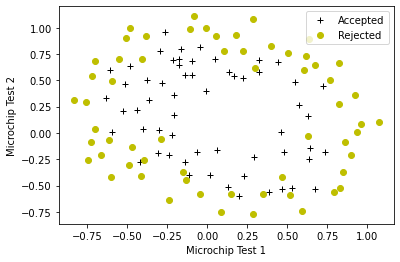

In [151]:
plot_data(X_train, y_train[:], pos_label="Accepted", neg_label="Rejected")

plt.ylabel('Microchip Test 2') 
plt.xlabel('Microchip Test 1') 
plt.legend(loc="upper right")
plt.show()

The figure shows that our dataset cannot be separated into positive and negative examples by a straight-line through the plot. Therefore, a straight forward application of logistic regression will not perform well on this dataset since logistic regression will only be able to find a linear decision boundary.

One way to fit the data better is to create more features from each data point. This is a technique called `Feature mapping`. In the provided function `map_feature`, we will map the features into all polynomial terms of $x_1$ and $x_2$ up to the sixth power.

$$\mathrm{map\_feature}(x) = 
\left[\begin{array}{c}
x_1\\
x_2\\
x_1^2\\
x_1 x_2\\
x_2^2\\
x_1^3\\
\vdots\\
x_1 x_2^5\\
x_2^6\end{array}\right]$$

As a result of this mapping, our vector of two features (the scores on two QA tests) has been transformed into a 27-dimensional vector. 

- A logistic regression classifier trained on this higher-dimension feature vector will have a more complex decision boundary and will be nonlinear when drawn in our 2-dimensional plot. 
- We have provided the `map_feature` function for you in utils.py. 

In [161]:
print("Original shape of data:", X_train.shape)

mapped_X =  map_feature(X_train[:, 0], X_train[:, 1])
print("Shape after feature mapping:", mapped_X.shape)

Original shape of data: (118, 2)
Shape after feature mapping: (118, 27)


Let's also print the first elements of `X_train` and `mapped_X` to see the tranformation.

In [165]:
print("The first element of the original feature:", X_train[0])
print("The first element of the mapped feature:\n", mapped_X[0])

The first element of the original feature: [0.051267 0.69956 ]
The first element of the mapped feature:
 [5.12670000e-02 6.99560000e-01 2.62830529e-03 3.58643425e-02
 4.89384194e-01 1.34745327e-04 1.83865725e-03 2.50892595e-02
 3.42353606e-01 6.90798869e-06 9.42624411e-05 1.28625106e-03
 1.75514423e-02 2.39496889e-01 3.54151856e-07 4.83255257e-06
 6.59422333e-05 8.99809795e-04 1.22782870e-02 1.67542444e-01
 1.81563032e-08 2.47750473e-07 3.38066048e-06 4.61305487e-05
 6.29470940e-04 8.58939846e-03 1.17205992e-01]


While the feature mapping allows us to build a more expressive classifier, it is also more susceptible to overfitting. Below, you will implement regularized logistic regression to fit the data and also see for yourself how regularization can help combat the overfitting problem.

### Cost function for regularized logistic regression

In this part, you will implement the cost function for regularized logistic regression.

Recall that for regularized logistic regression, the cost function is of the form
$$J(\mathbf{w},b) = \frac{1}{m}  \sum_{i=0}^{m-1} \left[ -y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) \right] + \frac{\lambda}{2m}  \sum_{j=0}^{n-1} w_j^2$$

Compare this to the cost function without regularization (which you implemented above), which is of the form 

$$ J(\mathbf{w}.b) = \frac{1}{m}\sum_{i=0}^{m-1} \left[ (-y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right)\right]$$

The difference is the regularization term, which is $$\frac{\lambda}{2m}  \sum_{j=0}^{n-1} w_j^2$$ 
Note that the $b$ parameter is not regularized.

While the feature mapping allows us to build a more expressive classifier, it is also more susceptible to overfitting. In the next parts of the exercise, you will implement regularized logistic regression to fit the data and also see for yourself how regularization can help combat the overfitting problem.

<a name="3.4"></a>
### 3.4 Cost function for regularized logistic regression

In this part, you will implement the cost function for regularized logistic regression.

Recall that for regularized logistic regression, the cost function is of the form
$$J(\mathbf{w},b) = \frac{1}{m}  \sum_{i=0}^{m-1} \left[ -y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) \right] + \frac{\lambda}{2m}  \sum_{j=0}^{n-1} w_j^2$$

Compare this to the cost function without regularization (which you implemented above), which is of the form 

$$ J(\mathbf{w}.b) = \frac{1}{m}\sum_{i=0}^{m-1} \left[ (-y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right)\right]$$

The difference is the regularization term, which is $$\frac{\lambda}{2m}  \sum_{j=0}^{n-1} w_j^2$$ 
Note that the $b$ parameter is not regularized.

In [166]:
def compute_cost_reg(X, y, w, b, lambda_ = 1):
    """
    Computes the cost over all examples
    Args:
      X : (array_like Shape (m,n)) data, m examples by n features
      y : (array_like Shape (m,)) target value 
      w : (array_like Shape (n,)) Values of parameters of the model      
      b : (array_like Shape (n,)) Values of bias parameter of the model
      lambda_ : (scalar, float)    Controls amount of regularization
    Returns:
      total_cost: (scalar)         cost 
    """

    m, n = X.shape
    
    # Calls the compute_cost function implemented above
    cost_without_reg = compute_cost(X, y, w, b) 
    
    # You need to calculate this value
    reg_cost = 0.
    
    for j in range(n):
        reg_cost += (w[j]**2)                                          
    # reg_cost = (lambda_/(2*m)) * reg_cost
    
    # Add the regularization cost to get the total cost
    total_cost = cost_without_reg + (lambda_/(2 * m)) * reg_cost
    return total_cost

In [200]:
X_mapped = map_feature(X_train[:, 0], X_train[:, 1])
np.random.seed(1)
initial_w = np.random.rand(X_mapped.shape[1]) - 0.5
initial_b = 0.5
lambda_ = 0.5
cost = compute_cost_reg(X_mapped, y_train, initial_w, initial_b, lambda_)

print("Regularized cost :", cost)

Regularized cost : 0.6618252552483948


### Gradient for regularized logistic regression

The gradient of the regularized cost function has two components. The first, $\frac{\partial J(\mathbf{w},b)}{\partial b}$ is a scalar, the other is a vector with the same shape as the parameters $\mathbf{w}$, where the $j^\mathrm{th}$ element is defined as follows:

$$\frac{\partial J(\mathbf{w},b)}{\partial b} = \frac{1}{m}  \sum_{i=0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})  $$

$$\frac{\partial J(\mathbf{w},b)}{\partial w_j} = \left( \frac{1}{m}  \sum_{i=0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) x_j^{(i)} \right) + \frac{\lambda}{m} w_j  \quad\, \mbox{for $j=0...(n-1)$}$$

Compare this to the gradient of the cost function without regularization (which you implemented above), which is of the form 
$$
\frac{\partial J(\mathbf{w},b)}{\partial b}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)})
$$
$$
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)})x_{j}^{(i)} 
$$


As you can see,$\frac{\partial J(\mathbf{w},b)}{\partial b}$ is the same, the difference is the following term in $\frac{\partial J(\mathbf{w},b)}{\partial w}$, which is $$\frac{\lambda}{m} w_j  \quad\, \mbox{for $j=0...(n-1)$}$$ 





In [201]:
def compute_gradient_reg(X, y, w, b, lambda_ = 1): 
    """
    Computes the gradient for linear regression 
 
    Args:
      X : (ndarray Shape (m,n))   variable such as house size 
      y : (ndarray Shape (m,))    actual value 
      w : (ndarray Shape (n,))    values of parameters of the model      
      b : (scalar)                value of parameter of the model  
      lambda_ : (scalar,float)    regularization constant
    Returns
      dj_db: (scalar)             The gradient of the cost w.r.t. the parameter b. 
      dj_dw: (ndarray Shape (n,)) The gradient of the cost w.r.t. the parameters w. 

    """
    m, n = X.shape
    
    dj_db, dj_dw = compute_gradient(X, y, w, b)


    for j in range(n):
        dj_dw[j] = dj_dw[j] + (lambda_/m) * w[j]         
        
    return dj_db, dj_dw

In [202]:
X_mapped = map_feature(X_train[:, 0], X_train[:, 1])
np.random.seed(1) 
initial_w  = np.random.rand(X_mapped.shape[1]) - 0.5 
initial_b = 0.5
 
lambda_ = 0.5
dj_db, dj_dw = compute_gradient_reg(X_mapped, y_train, initial_w, initial_b, lambda_)

print(f"dj_db: {dj_db}", )
print(f"First few elements of regularized dj_dw:\n {dj_dw[:4].tolist()}")

dj_db: 0.07138288792343662
First few elements of regularized dj_dw:
 [-0.010386028450548703, 0.011409852883280122, 0.0536273463274574, 0.003140278267313462]


### Learning parameters using gradient descent

Similar to the previous parts, we will use the gradient descent function implemented above to learn the optimal parameters $w$,$b$. 
- If you have completed the cost and gradient for regularized logistic regression correctly, you should be able to step through the next cell to learn the parameters $w$. 
- After training our parameters, we will use it to plot the decision boundary. 

**Note**

The code block below takes quite a while to run, especially with a non-vectorized version. You can reduce the `iterations` to test your implementation and iterate faster. If you have time, run for 100,000 iterations to see better results.

In [203]:
np.random.seed(1)
initial_w = np.random.rand(X_mapped.shape[1])-0.5
initial_b = 1.

lambda_ = 0.01;                                          
iterations = 10000
alpha = 0.01

w,b, J_history,_ = gradient_descent(X_mapped, y_train, initial_w, initial_b, compute_cost_reg, compute_gradient_reg, alpha, iterations, lambda_)

Iteration    0: Cost     0.72   
Iteration 1000: Cost     0.59   
Iteration 2000: Cost     0.56   
Iteration 3000: Cost     0.53   
Iteration 4000: Cost     0.51   
Iteration 5000: Cost     0.50   
Iteration 6000: Cost     0.48   
Iteration 7000: Cost     0.47   
Iteration 8000: Cost     0.46   
Iteration 9000: Cost     0.45   
Iteration 9999: Cost     0.45   


### Plotting the decision boundary
To help visualize the model learned by this classifier, we will use our `plot_decision_boundary` function which plots the (non-linear) decision boundary that separates the positive and negative examples. 

In the function, we plotted the non-linear decision boundary by computing the classifier’s predictions on an evenly spaced grid and then drew a contour plot of where the predictions change from y = 0 to y = 1.

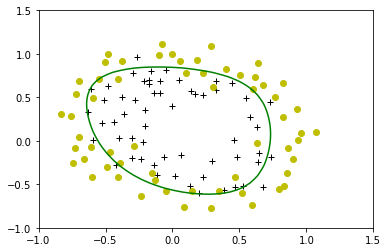

In [204]:
plot_decision_boundary(w, b, X_mapped, y_train)

### Evaluating the regularized model (Logistic Regression)
Use the `predict` function implemented above to calculate the accuracy of the regulaized logistic regression model on the training set

In [209]:
p = predict(X_mapped, w, b)
print('Train Accuracy: %f' %(np.mean(p == y_train) * 100))

Train Accuracy: 82.203390
